In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

%matplotlib inline

In [2]:
#nltk.download('punkt')

In [3]:
data = pd.read_csv("output_merged_25oct.csv", encoding='latin-1')
data.head()

,COMPANY,COUNTRY,DISTRIBUTOR,ARTICLE ID,MODEL NUMBER,ARTICLE NAME,SUBBRAND,SPORTS CATEGORY,PRODUCT DIVISION,PRODUCT GROUP,...,CURRENT PRICE IN EUR,INITIAL PRICE IN SELECTED CURRENCY,CURRENT PRICE IN SELECTED CURRENCY,SELECTED CURRENCY,PRODUCT INTRODUCTION DATE,DISCOUNTED SINCE,PRODUCT EXIT DATE,PRODUCT DESCRIPTION,PRODUCT URL,IMAGE-SERVER URL
0,Nike,USA,Own eCom,837786-603,837786,KD 8 'Aunt Pearl' Premium Big Kids' Basketball...,Performance,Basketball,Footwear,Performance Footwear,...,56.5239,121.80,56.5239,EUR,2/29/2016,11/9/2016,9/18/2017,DYNAMIC VERSATILITY. INSPIRED STYLE.; The KD 8...,https://store.nike.com/us/en_us/pd/kd-8-aunt-p...,http://usporamap287.am.adsint.biz/zoomimages/1...
1,Nike,USA,Own eCom,810455-421,810455,LeBron 13 Transportation Kids' Adjustable Hat,Sport Inspired,Lifestyle,Accessories,Headwear,...,17.3739,24.36,17.3739,EUR,2/29/2016,4/4/2016,5/2/2016,LEBRON TRANSPORTATION HAT The LeBron 13 Transp...,http://store.nike.com/us/en_us/pd/lebron-13-tr...,http://usporamap287.am.adsint.biz/zoomimages/1...
2,Nike,USA,Own eCom,807940-010,807940,Nike SB Cherry Blossom Perforated Trucker Hat,Sport Inspired,Skate,Accessories,Headwear,...,27.8400,27.84,27.8400,EUR,2/29/2016,Not discounted yet,3/21/2016,BREATHABLE COMFORT The Nike SB Cherry Blossom ...,http://store.nike.com/us/en_us/pd/sb-cherry-bl...,http://usporamap287.am.adsint.biz/zoomimages/1...
3,Nike,USA,Own eCom,749502-100,749502,Nike Cortez Big Kids' Shoe,Sport Inspired,Lifestyle,Footwear,Sport Inspired Footwear,...,39.1239,52.20,39.1239,EUR,2/29/2016,2/9/2017,4/10/2017,"A CLASSIC, REBORN. The Nike Cortez BigÂ Kids' ...",http://store.nike.com/us/en_us/pd/cortez-big-k...,http://usporamap287.am.adsint.biz/zoomimages/1...
4,Nike,USA,Own eCom,746735-404,746735,Nike Golf AW84 OX Adjustable Hat,Performance,Golf,Accessories,Headwear,...,17.3739,20.88,17.3739,EUR,2/29/2016,6/30/2016,10/10/2016,PREMIUM LOOK. LIGHTWEIGHT FIT. The Nike Golf A...,http://store.nike.com/us/en_us/pd/golf-aw84-ox...,http://usporamap287.am.adsint.biz/zoomimages/1...


In [4]:
data.isnull().sum()

COMPANY                                    0
COUNTRY                                    0
DISTRIBUTOR                                0
ARTICLE ID                                 0
MODEL NUMBER                               0
ARTICLE NAME                              19
SUBBRAND                                   0
SPORTS CATEGORY                            0
PRODUCT DIVISION                           0
PRODUCT GROUP                              0
PRODUCT TYPE                               0
FRANCHISE                                 20
TECHNOLOGIES                          146388
COLOUR GROUP                               0
COLOUR                                  7285
GENDER                                     0
AGE GROUP                                  0
CONSUMER RATING                            0
INITIAL PRICE IN LOCAL CURRENCY            0
CURRENT PRICE IN LOCAL CURRENCY            0
LOCAL CURRENCY                             0
INITIAL PRICE IN EUR                       0
CURRENT PR

In [5]:
data.COUNTRY.unique()

array(['USA', 'Germany', 'Japan'], dtype=object)

In [6]:
data.SUBBRAND.unique()

array(['Performance', 'Sport Inspired'], dtype=object)

In [7]:
# Filtering US
data = data.loc[data["COUNTRY"].isin(['USA'])]

In [8]:
#data.group.unique()

In [9]:
data_req = data.loc[:,["COMPANY", "COUNTRY", "ARTICLE NAME","SUBBRAND", "PRODUCT DESCRIPTION", "PRODUCT URL"]]

In [10]:
data_req = data_req.drop_duplicates()

In [11]:
len(data_req)

107163

In [12]:
data_req_x = data_req.loc[:,["COMPANY", "COUNTRY", "ARTICLE NAME", "PRODUCT DESCRIPTION", "PRODUCT URL"]]
data_req_y = data_req.loc[:, ["SUBBRAND"]]

In [13]:
data_req_x = data_req_x.fillna("unknown")
data_req = pd.concat([data_req_x, data_req_y], axis=1)

In [14]:
len(data_req)

107163

In [15]:
data_req = data_req.dropna()

In [16]:
data_req = data_req.drop_duplicates()

In [17]:
data_req["description"]  = data_req["COMPANY"] +" " + data_req["COUNTRY"] +" " + data_req["ARTICLE NAME"] +" " + data_req["PRODUCT DESCRIPTION"]+" " + data_req["PRODUCT URL"]

In [18]:
data_req = data_req.drop(["COMPANY", "COUNTRY", "ARTICLE NAME", "PRODUCT DESCRIPTION", "PRODUCT URL"], axis = 1)

In [19]:
data_req.columns = ["subBrand", "description"]

In [20]:
data_req.subBrand.unique()

array(['Performance', 'Sport Inspired'], dtype=object)

In [21]:
len(data_req)

107163

In [22]:
data_req = data_req.drop_duplicates()

In [23]:
data_req.subBrand = data_req.subBrand.str.lower()
data_req.description = data_req.description.str.lower()

In [24]:
data_req.subBrand.unique()

array(['performance', 'sport inspired'], dtype=object)

In [25]:
lens = data_req.description.str.len()
lens.mean(), lens.std(), lens.max()

(586.939148773364, 312.7309138788855, 4263)

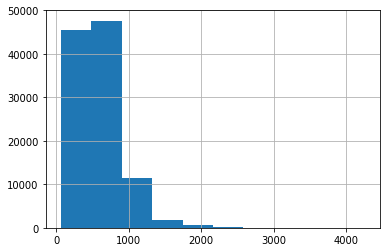

In [26]:
lens.hist();

In [27]:
data_req = data_req.dropna()

In [28]:
len(data_req)

107163

In [29]:
one_hot = pd.get_dummies(data_req.subBrand)

In [30]:
label_cols = data_req.subBrand.dropna().unique()

In [31]:
label_cols

array(['performance', 'sport inspired'], dtype=object)

In [32]:
minCount = 10
subBrand_minCount = pd.DataFrame((data_req.subBrand.value_counts() > minCount).reset_index())

In [33]:
subBrand_drop = subBrand_minCount.loc[subBrand_minCount["subBrand"] == False]

In [34]:
subBrand_drop

,index,subBrand


In [35]:
label_cols = np.setdiff1d(label_cols, subBrand_drop["index"])

In [36]:
data_req = pd.concat([data_req, one_hot], axis=1)

In [37]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [38]:
description = "description"

In [39]:
data_req = data_req.drop(subBrand_drop["index"], axis = 1)

In [40]:
np.random.seed(123)
data_req_sample = data_req.sample(frac=0.7)

In [41]:
train = data_req.loc[data_req.index.isin(data_req_sample.index)]
test = data_req.loc[~data_req.index.isin(data_req_sample.index)]

In [42]:
test_subBrand = test.subBrand

In [43]:
train = train.drop("subBrand", axis = 1)
test = test.drop("subBrand", axis = 1)

In [44]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('english')
# stop_words_german = get_stop_words('german')

In [45]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words = stop_words_english)
trn_term_doc = vec.fit_transform(train[description])
test_term_doc = vec.transform(test[description])

In [46]:
trn_term_doc, test_term_doc

(<75014x214782 sparse matrix of type '<class 'numpy.float64'>'
 	with 10675369 stored elements in Compressed Sparse Row format>,
 <32149x214782 sparse matrix of type '<class 'numpy.float64'>'
 	with 4528839 stored elements in Compressed Sparse Row format>)

In [47]:
x = trn_term_doc
test_x = test_term_doc

In [48]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization

In [49]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [50]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [51]:
label_cols

array(['performance', 'sport inspired'], dtype=object)

In [ ]:
folds = 3
param_comb = 5

preds = np.zeros((len(test), len(label_cols)))

clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=1)

skf =  StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

start_time = timer(None)
for i, j in enumerate(label_cols):
    print('fit', j)
    random_search = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(x,train[j]), verbose=3)
    random_search.fit(x, train[j])
    preds[:,i] = random_search.predict_proba(test_x)[:,1]
timer(start_time)

fit performance
Fitting 3 folds for each of 405 candidates, totalling 1215 fits


In [63]:
#clf.predict_proba(test_x)[:,1]

In [64]:
preds.shape

(80597, 2)

In [65]:
predictions = pd.DataFrame(preds, columns = label_cols)

In [66]:
test.index = np.arange(0, len(test))
test_subBrand.index = np.arange(0, len(test))

In [67]:
len(test)

80597

In [68]:
submid = pd.DataFrame({'description': test["description"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)

In [69]:
submission.head()

,description,performance,sport inspired
0,"nike usa nike cortez big kids' shoe a classic,...",0.502917,0.497083
1,nike germany nike performance low-cut socken f...,0.542963,0.457037
2,nike usa nike jr. tiempo legend vi tf kids' tu...,0.887141,0.112859
3,nike usa nike mercurial victory v tf kids' tur...,0.852152,0.147848
4,nike usa nike jr. mercurial victory v ic kids'...,0.867068,0.132932


In [70]:
final_pred = pd.concat([submission, test_subBrand.str.lower()],axis = 1)

In [71]:
data.SUBBRAND.value_counts()

Performance       160306
Sport Inspired    110859
Name: SUBBRAND, dtype: int64

In [72]:
test_subBrand.str.lower().value_counts()

performance       47637
sport inspired    32960
Name: subBrand, dtype: int64

In [73]:
final_pred["Predictions"] = final_pred[label_cols].idxmax(axis = 1)

In [74]:
from mlxtend.evaluate import confusion_matrix

y_target =    final_pred.subBrand
y_predicted = final_pred.Predictions

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted, 
                      binary=False)

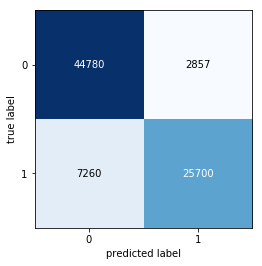

In [75]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [76]:
print(f'Accuracy Score : {accuracy_score(final_pred.subBrand, final_pred.Predictions)}')
print(f'F1 Score: {f1_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')
print(f'Precision: {precision_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')
print(f'Recall: {recall_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')

Accuracy Score : 0.8744742360137474
F1 Score: 0.8670217785223667
Precision: 0.8802232031480279
Recall: 0.8598793100268189


In [88]:
#final_pred.to_csv("final_output_SubBrand_v4.csv", index_label=False, index=False)

In [83]:
len(final_pred)

20860

In [51]:
#test_subBrand

In [52]:
len(submission)

15062

In [54]:
#final_pred.isnull().sum()